In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.15.0


In [2]:
(X_train, y_train) , (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
num_classes = len(np.unique(y_train))
category = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

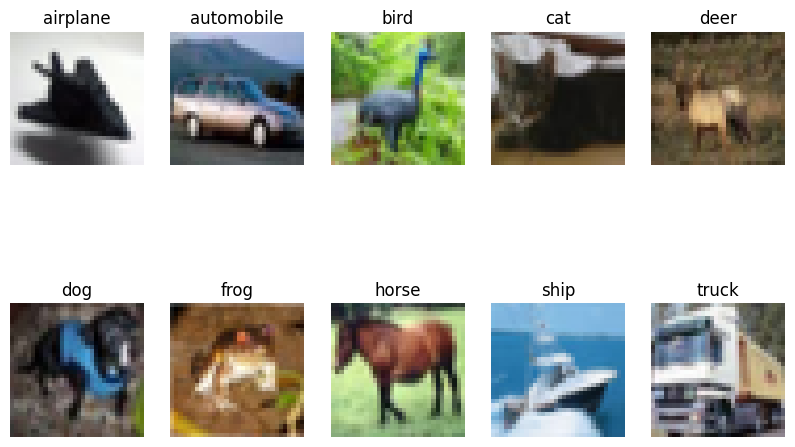

In [4]:
#plotting the image of every class
plt.figure(figsize = (10,10))
for i in range (num_classes):
    axs = plt.subplot(3, 5, i+1)
    idx = np.where(y_train[:]==i)[0]
    x = X_train[idx,::]
    plt.imshow(x[0])
    axs.set_title(category[i])
    plt.axis("off")

In [5]:
import cv2

def preprocess_image_input(inputs):
    """
    Preprocesses the image data by resizing the images to be 224x224 pixels.
    """
    processed_images = []
    for image in inputs:
        new_image = cv2.resize(image, (224, 224))
        processed_images.append(new_image)
    return np.array(processed_images)

In [6]:
X_train = preprocess_image_input(X_train)
X_test = preprocess_image_input(X_test)

In [7]:
input_size = (224, 224)

In [13]:
inputs = tf.keras.layers.Input(shape=input_size + (3,))
extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')(inputs)
r = tf.keras.layers.GlobalAveragePooling2D()(extractor)
r = tf.keras.layers.Flatten()(r)
r = tf.keras.layers.Dense(1024, activation="relu")(r)
r = tf.keras.layers.Dense(512, activation="relu")(r)
outputs = tf.keras.layers.Dense(len(category), activation="softmax", name="classification")(r)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                           

In [10]:
# Reshape the target tensor to have the correct shape
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=3, validation_split=0.2, batch_size=16)

Epoch 1/3
2500/2500 [==============================] - 2549s 1s/step - loss: 0.4174 - accuracy: 0.8570 - val_loss: 0.2706 - val_accuracy: 0.9104
Epoch 2/3
2500/2500 [==============================] - 2658s 1s/step - loss: 0.1489 - accuracy: 0.9483 - val_loss: 0.1985 - val_accuracy: 0.9372
Epoch 3/3
2500/2500 [==============================] - 2703s 1s/step - loss: 0.0763 - accuracy: 0.9744 - val_loss: 0.2355 - val_accuracy: 0.9268


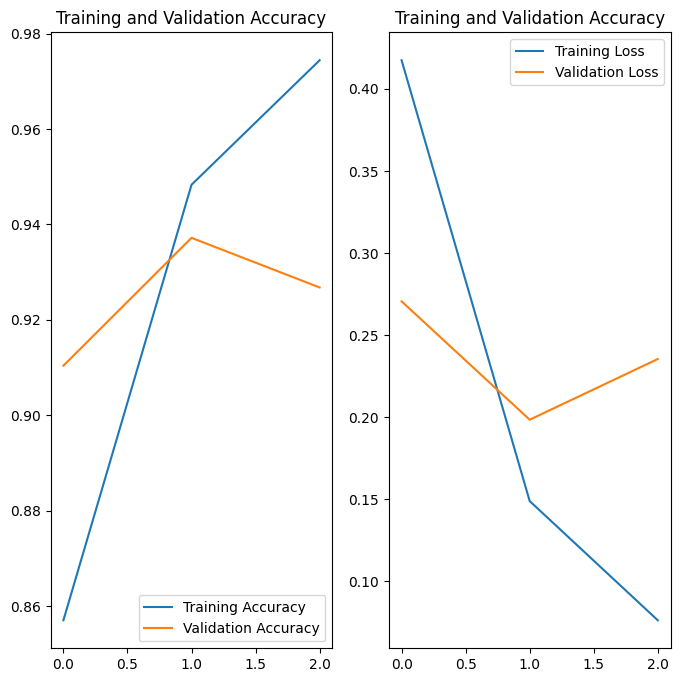

In [15]:
#plotting the loss and accuracy curve

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')
plt.show()

In [16]:
# Reshape the target tensor to have the correct shape
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [17]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test)
print('Test Accuracy of Base Model: {}'.format(evaluation[1]))

313/313 [==============================] - 167s 530ms/step - loss: 0.2576 - accuracy: 0.9233
Test Accuracy of Base Model: 0.92330002784729


In [18]:
predict = model.predict(X_test)
print(predict)
predLabel = np.argmax(predict, axis=1)
print(predLabel)

313/313 [==============================] - 164s 520ms/step
[[2.40403988e-05 3.35788536e-05 1.43639289e-03 ... 4.75126342e-07
  1.35185728e-05 2.22176982e-06]
 [2.51121614e-02 3.36881098e-03 1.73296881e-04 ... 1.20969162e-06
  9.71247494e-01 7.11622779e-05]
 [8.97451711e-04 1.10467272e-02 9.86018422e-05 ... 4.16124749e-05
  9.87211585e-01 6.24737411e-04]
 ...
 [2.93245904e-07 7.49619971e-07 8.39550466e-07 ... 5.09704563e-08
  3.06016460e-07 6.62329853e-08]
 [4.59735674e-07 9.99999106e-01 4.39922729e-08 ... 3.75765322e-11
  1.09076215e-08 2.46117281e-07]
 [7.73327073e-08 5.74701858e-07 8.65187360e-07 ... 9.99996006e-01
  6.90812882e-08 2.62016641e-07]]
[3 8 8 ... 5 1 7]


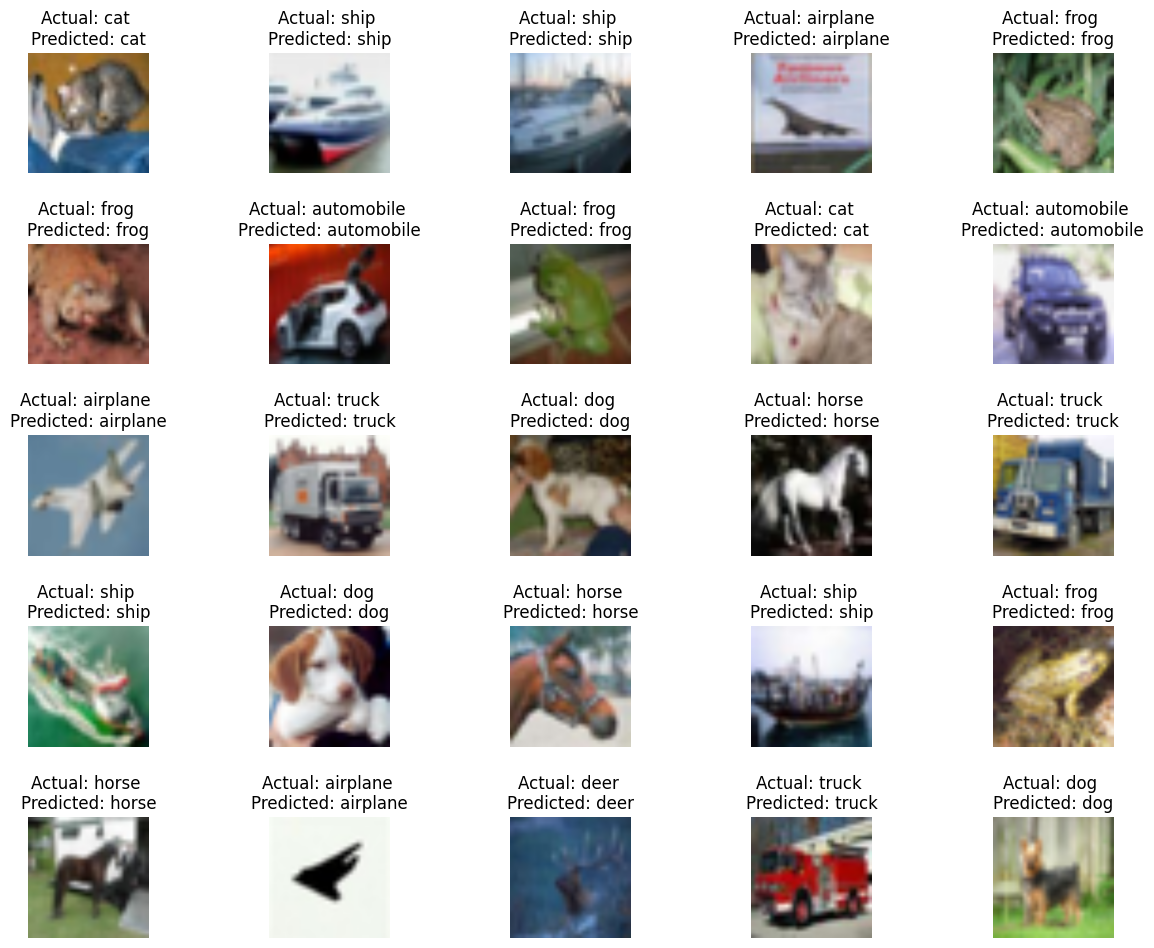

In [19]:
# Evaluate the model against test images to perform predictions

fi, ax = plt.subplots(5, 5, figsize=(14,12))
ax = ax.ravel()

for i in np.arange(0, 25):
    ax[i].imshow(X_test[i])
    ax[i].set_title("Actual: %s \nPredicted: %s" % (category[np.argmax(y_test[i])], category[predLabel[i]] ))
    ax[i].axis('off')
    plt.subplots_adjust(wspace=1)